## Initialization

In [5]:
import sys
#sys.path.append('/Users/chandrasekharmukherjee/Home/Centrality framework/Modules')
sys.path.append('I:/내 드라이브/backup/document/USC/Research/MCPC/Code/Codes')

#Import packages
#imports
import time
import pandas as pd
from collections import Counter
import sknetwork


from sknetwork.ranking import PageRank
from sknetwork.ranking import Betweenness
from sknetwork.ranking import Closeness

#import umap as umap

from numba.typed import List
import warnings
from numba import njit
import pynndescent
import numpy as np
from sklearn.cluster import SpectralClustering
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib
import operator
from sklearn.utils.extmath import randomized_svd
from random import randint
from sklearn.utils.extmath import randomized_svd
from sklearn.decomposition import TruncatedSVD
import scipy
#from umap.umap_ import *
import math
from random import randint
import keras
from keras.datasets import mnist
from keras.datasets import cifar10
from keras.datasets import cifar100
from keras.datasets import fashion_mnist
import scanpy
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics import adjusted_mutual_info_score, roc_auc_score
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics.cluster import adjusted_mutual_info_score

#import community as community_louvain
from sklearn.cluster import KMeans
from sklearn.metrics import fowlkes_mallows_score

import scipy

import igraph 
import networkx as nx


import metric as met 
import embedding as embed   
import data_utils_ch as data_util

%load_ext autoreload
%autoreload 2
import importlib

import metric as met 
import embedding as embed   
import data_utils_ch as data_util
from subgraph import *


met=importlib.reload(met)
embed=importlib.reload(embed)
data_util=importlib.reload(data_util)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Testing every dataset with top k % nodes induced subgraph (Louvain)

### Top k% induced subgraph + Strong Majority Vote later

##### PDF Export version (Final Working Version)

In [15]:
import Cust_Top as Cust
import networkx.algorithms.community.louvain as Louv
from sklearn.metrics.cluster import normalized_mutual_info_score as NMI
from collections import deque
from matplotlib.backends.backend_pdf import PdfPages
import os
from subgraph import * 
import time 
import debug
from collections import defaultdict
import leidenalg as la 
import igraph as ig

res_=[] #0.26, 0.24 is best for Louvain, 3.3, 2.0
labels=[]
total_labels=[]
names = []

data_names = ['Zhengmix8eq','mRNA','miRNA','FashionMNIST','MNIST','seeds','breast-cancer','Omniglot','bbc_news','20NewsGroups_tfdif','biorxiv','big_patent','Cora','Cora full','Citeseer','Eu core']
#data_names = ['mRNA','miRNA','FashionMNIST','MNIST','seeds','breast-cancer','Omniglot','bbc_news','20NewsGroups_tfdif','biorxiv','big_patent','Cora','Cora full','Citeseer','Eu core']
#data_names = ['mRNA']
#data_names = ['Zhengmix8eq']
'''
datasets with nodes that have no outgoing edges : 
['Cora full', 'Citeseer', 'Eu core']
'''
#data_names = ['Cora full', 'Citeseer', 'Eu core']
# FR_ord = ['Rd', 'Ord']
# FR_Recalc = ['FR_avg', 'FR_Re']
FR_tp = ['FL','FL_ng','FL_ng_prop','PageRank']
FR_tp_short = ['FL','FL_ng','FL_ng_p','PR']
Num_hops = {0:'5',1:'log(n)'}
Mod_tp = {0: 'Louv'}

#top k% nodes for induced subgraph
k=0.2
traverse = {0:'Reset',1:'Static'}
ord = {0:'Rand',1:'FR_order'}

#list of plotted figures
figures = []

for data in data_names: 
    pdf_name = './Plots/'+data+'/fixed_'+data+'.pdf'
    
    
    for survive in [0]:
        '''
        Get the Graph from Edge_List and get the labels
        '''
        #DO not recalculate Graph for non bulk RNA datasets
        if data not in ['mRNA','miRNA'] and survive==1:
            continue
        G, label= data_to_graph(data,survive)
        cluster_sizes = defaultdict(int)
        for node in G.nodes():
            cluster_sizes[label[node]]+=1
        #print('Selected Labels:',selected_labels_dict)
        #add self loop to nodes without outgoing edges
        #G_ is copy of G
        G_ = G.copy()
        # if (data in ['Cora full', 'Citeseer', 'Eu core']):
        #     for node in G.nodes():
        #         if not list(G.successors(node)):
        #             G_.remove_node(node)
        for node in G_.nodes():
            if not list(G_.successors(node)):
                #print(data, ' has a node without outgoing edges:',node)
                G_.add_edge(node, node, weight=1)
        print('Number of nodes:',G.number_of_nodes())
        

        data_directory = f'./Plots/{data}'
        file_path = f'{data_directory}/{data}.txt'
        os.makedirs(data_directory, exist_ok=True)
        with open(file_path, 'w') as f:
            f.write('------------------------------------------------------------------------\n')
        
        
            
        for Num_hop in [1]:
            plt.figure(figsize=(10,15)) # figure for NMI vs purity
            plt.figure(figsize=(10,6)) # figure for NMI vs Purity (whole)
            plt.figure(figsize=(10,15)) # figure for NMI
            plt.figure(figsize=(10,15)) # figure for Purity
            plt.figure(figsize=(10,15)) # figure for preserve_ratio
            plt.figure(figsize=(10,15)) # figure for balancedness
            plt.figure(figsize=(10,15)) # figure for InEdge Degrees
            #List of FR_values
            FR_precalculated = []
            for fr_type in range(4): 
                '''
                Calculate FlowRank for the whole graph
                '''
                if Num_hop==0:
                    node2FR = calc_FlowRank(G_, fr_type, 5)
                else:
                    node2FR = calc_FlowRank(G_, fr_type, np.log2(G.number_of_nodes()))
                FR_precalculated.append(node2FR)

            for idx, res in enumerate([0.05,0.25, 0.5, 1, 1.5, 5]):
            #for idx, res in enumerate([0.05]):
            #for idx, res in enumerate([0.01,0.03,0.05,0.1,0.15,0.2]):
                for Mod_type in [0]:
                    ''' 
                    Louvain on G (baseline)
                    '''
                    partition = debug.louvain_partitions(G, seed=0,resolution=res)
                    partition_ = deque(partition, maxlen=1).pop()
                    label_ = part_to_full_label(partition_,G.number_of_nodes())
                    NMI_baseline = NMI(label_, label)
                    Purity_baseline = met.purity_score(label, label_)
                    
                    '''
                    Leiden on G (Baseline)
                    '''
                    G_ig = ig.Graph.from_networkx(G)
                    partition = la.find_partition(G_ig, la.RBConfigurationVertexPartition, n_iterations=-1, resolution_parameter=res)
                    for i, community in enumerate(partition):
                        for node in community:
                            label_[node] = i
                    NMI_baseline_leiden = NMI(label, label_)
                    Purity_baseline_leiden = met.purity_score(label, label_)
                    print('NMI baseline Leiden:', round(NMI_baseline_leiden,3), 'Purity baseline Leiden:', round(Purity_baseline_leiden,3))
                    
                    for FR_type in range(4):
                        name =  data + ' (top ' + str(k*100) + '%): '+ str(FR_tp[FR_type]) + ' + '+ str(Num_hops[Num_hop]) +' hops'
                        if FR_type==3:
                            name = data + ' (top ' + str(k*100) + '%): PageRank'
                        if data in ['mRNA','miRNA']:
                            name = data +  ' (top ' + str(k*100) + '%): '+ str(FR_tp[FR_type]) + ' + '+ str(Num_hops[Num_hop]) +' hops' + ' + Survive: '+str(survive)
                            if FR_type==3:
                                name = data + ' (top ' + str(k*100) + '%): PageRank' + ' + Survive: '+str(survive)
                        print(' ---',name,'| res: ',str(res))
                        
                        # Create the directory if it doesn't exist
                        os.makedirs(data_directory, exist_ok=True)
                        with open(file_path, 'a') as f:
                            f.write(' ---'+name+'| res: '+str(res)+'\n')
                            f.write('NMI baseline: ' + str(round(NMI_baseline,3)) + '\n')
                        

                        '''
                        Get induced subgraph of top k% nodes in FR value
                        '''
                        node2FR = FR_precalculated[FR_type]
                        
                        # if data in ['Cora full', 'Citeseer', 'Eu core']:
                        #     for node in G.nodes():
                        #         if not list(G.successors(node)):
                        #             node2FR[node]=0

                        node_list = sorted(G.nodes, key=lambda x: node2FR[x], reverse=True)
                        #print('Time sort:', time.time()-start_time)
                        
                        k_ = int(k*len(node_list))
                        top_nodes = node_list[:k_]
                        H = getInducedSubgraph(G, top_nodes) # H = induced subgraph
                        #print('Time Induced Subgraph:', time.time()-start_time)
                        
                        '''
                        label counts for balancedness calculation
                        '''
                        selected_labels_dict = defaultdict(int)
                        for node in H.nodes():
                            selected_labels_dict[label[node]]+=1
                        

                        '''
                        Louvain on the subgraph H 
                        '''
                        # partition = RC10.louvain_partitions(H, seed=0,resolution=res, FR_type=FR_type, Mod_type=Mod_type)
                        #partition = Louv.louvain_partitions(H, seed=0,resolution=res ,threshold=0.0001)
                        
                        partition = debug.louvain_partitions(H, seed=0,resolution=res)
                        partition_ = deque(partition, maxlen=1).pop()
                        H_label = part_to_full_label(partition_,G.number_of_nodes())
                        #print('Time Louvain:', time.time()-start_time)
        
                        '''Run Louvain Again on the rest ( Warm Start )'''
                        #start_time = time.time()

                        k_ = int(k*len(node_list))
                        nodes_rest = node_list[k_:]
                        
                        for node in nodes_rest:
                            partition_.append({node})
                        part = Cust.louvain_partitions(G, seed=0,resolution=res,init_part=partition_)
                        part_ = deque(part, maxlen=1).pop()
                        label_ = part_to_full_label(part_,G.number_of_nodes())
                        NMI_twice = NMI(label_, label)
                        Purity_twice = met.purity_score(label, label_)
                        #print('Time Louvain twice:', time.time()-start_time)
                        print('NMI baseline:', round(NMI_baseline,3))
                        print('NMI Louvain twice:', round(NMI_twice,3))


                        '''
                        Add nodes to the subgraph by strong majority vote
                        '''
                        #See the trend by adding node to the subgraph by strong majority vote (in order of FlowRank Value)
                        
                        #print('H_label: ',H_label, 'len: ',len(H_label))
                        
                        
                        #start_time = time.time()
                        NMI_List, Purity_List, Balance_List, Preserv_List, InEdge_List = merge_by_vote(top_nodes, nodes_rest, H_label, G, label, selected_labels_dict, cluster_sizes)
                        #print('Time merge by vote:', time.time()-start_time)
                        
                        #Plot NMI_List
                        fig_numbers = plt.get_fignums()
                        NMI_vs_Purity = fig_numbers[-7]
                        NMI_vs_Purity_whole = fig_numbers[-6]
                        nmi_fig =fig_numbers[-5]
                        purity_fig = fig_numbers[-4]
                        preserve_fig = fig_numbers[-3]
                        balance_fig = fig_numbers[-2]
                        InEdge_fig = fig_numbers[-1]
                        

                        max_dot_size = 100
                        #plot NMI vs Purity
                        markers = ['o','s','*','^','h','D'] #idx (resolution)
                        colors = ['b','g','y','r'] #FR_type
                        plt.figure(NMI_vs_Purity)
                        plt.subplot(3,2,idx+1)
                        percent_nodes = (H.number_of_nodes() + len(NMI_List))*100 / G.number_of_nodes()
                        #plt.scatter(Purity_List[-1], NMI_List[-1], color = colors[FR_type], s = percent_nodes*max_dot_size, marker = markers[idx],label = str(FR_tp[FR_type])+ '|'+str(round(percent_nodes,2))+ '% nodes')
                        plt.scatter(Purity_List[-1], NMI_List[-1], color = colors[FR_type], s = percent_nodes/100*max_dot_size,label = str(FR_tp[FR_type])+ '|'+str(round(percent_nodes,2))+ '% nodes')
                        if FR_type==0:
                            plt.scatter(Purity_baseline, NMI_baseline, color = 'k', s = max_dot_size,label = 'Louv_baseline')
                            plt.scatter(Purity_baseline_leiden, NMI_baseline_leiden, color = 'm', s = max_dot_size,label = 'Leiden_baseline')
                            #plt.scatter(Purity_baseline, NMI_baseline, color = 'k', s = max_dot_size*0.5, marker = markers[idx],label = 'Louv_baseline|'+str(res))
                        #plt.scatter(Purity_twice, NMI_twice, color = 'm', s = max_dot_size, marker = markers[idx],label = '2*Louv|'+str(res))

                        #plot NMI vs Purity (whole)
                        plt.figure(NMI_vs_Purity_whole)
                        plt.scatter(Purity_List[-1], NMI_List[-1], color = colors[FR_type], s = percent_nodes/100*max_dot_size, marker = markers[idx],label = str(FR_tp[FR_type])+ '|'+str(res)+'|'+str(round(percent_nodes,2))+ '% nodes')
                        if FR_type==0:
                            plt.scatter(Purity_baseline, NMI_baseline, color = 'k', s = max_dot_size, marker = markers[idx],label = 'Louv_baseline|'+str(res))
                            plt.scatter(Purity_baseline_leiden, NMI_baseline_leiden, color = 'm', s = max_dot_size, marker = markers[idx],label = 'Leiden_baseline|'+str(res))
                        #plt.scatter(Purity_twice, NMI_twice, color = 'm', s = max_dot_size, marker = markers[idx],label = '2*Louv|'+str(res))

                        #plot NMI
                        plt.figure(nmi_fig)
                        plt.subplot(3, 2, idx+1)
                        plt.plot(NMI_List,  color = colors[FR_type], label = str(FR_tp[FR_type]))

                        if FR_type==0: 
                            #Horizontal Line for Baselines
                            NMI_baseline_list = [NMI_baseline]*len(nodes_rest)
                            plt.plot(NMI_baseline_list, label = 'Louv_baseline')
                            NMI_baseline_leiden_list = [NMI_baseline_leiden]*len(nodes_rest)
                            plt.plot(NMI_baseline_leiden_list, label = 'Leiden_baseline')
                        #NMI_Louv_twice_list = [NMI_twice]*len(nodes_rest)
                        #plt.plot(NMI_Louv_twice_list, label = '2*Louv|'+str(FR_tp_short[FR_type]))
                        
                        with open(file_path, 'a') as f:
                            f.write('# of nodes not included: ' + str(G.number_of_nodes() - H.number_of_nodes() - len(NMI_List)+1) + '\n')
                            f.write('NMI_Louvain_twice: ' + str(round(NMI_twice,3)) + '\n')
                            f.write('NMI after top ' + str(k*100) + '% nodes: ' + str(round(NMI_List[0],3)) + '\n')
                            f.write('Max NMI: ' + str(round(max(NMI_List),3)) + '\n')
                        print('Number of nodes not included: ' , G.number_of_nodes() - H.number_of_nodes() - len(NMI_List)+1) 
                        print('NMI after top ', k*100, '% nodes:', round(NMI_List[0],3))
                        print('Max NMI: ', round(max(NMI_List),3))

                        #plot Purity
                        plt.figure(purity_fig)
                        plt.subplot(3, 2, idx+1)
                        plt.plot(Purity_List,  color = colors[FR_type], label = str(FR_tp[FR_type]))
                        if FR_type==0: 
                            #Horizontal Line for Baselines
                            Purity_baseline_list = [Purity_baseline]*len(nodes_rest)
                            plt.plot(Purity_baseline_list, label = 'Louv_baseline')
                            Purity_baseline_leiden_list = [Purity_baseline_leiden]*len(nodes_rest)
                            plt.plot(Purity_baseline_leiden_list, label = 'Leiden_baseline')
                    
                        #Purity_Louv_twice_list = [Purity_twice]*len(nodes_rest)
                        #plt.plot(Purity_Louv_twice_list, label = '2*Louv|'+str(FR_tp_short[FR_type]))
                        
                        with open(file_path, 'a') as f:
                            f.write('Purity_Louvain_twice: ' + str(round(Purity_twice,3)) + '\n')
                            f.write('Purity after top ' + str(k*100) + '% nodes: ' + str(round(Purity_List[0],3)) + '\n')
                            f.write('Max Purity: ' + str(round(max(Purity_List),3)) + '\n')

                        #plot preserve_ratio
                        plt.figure(preserve_fig)
                        plt.subplot(3, 2, idx+1)
                        plt.plot(Preserv_List,  color = colors[FR_type], label = str(FR_tp[FR_type]))

                        #plot balancedness
                        plt.figure(balance_fig)
                        plt.subplot(3, 2, idx+1)
                        plt.plot(Balance_List,  color = colors[FR_type], label = str(FR_tp[FR_type])) 

                        #plot InEdge Degrees
                        plt.figure(InEdge_fig)
                        plt.subplot(3, 2, idx+1)
                        plt.plot(InEdge_List,  color = colors[FR_type], label = str(FR_tp[FR_type]))
                    
                plt.figure(NMI_vs_Purity)
                plt.tight_layout()
                plt.subplot(3,2,idx+1)
                plt.xlabel('Purity')
                plt.ylabel('NMI')
                plt.title(data + ' | top ' + str(k*100) + '%' + '| Num_hops: ' + str(Num_hops[Num_hop]) + '|res: ' + str(res)+ '|')
                #plt.legend()
                plt.legend()

                plt.figure(NMI_vs_Purity_whole)
                plt.xlabel('Purity')
                plt.ylabel('NMI')
                plt.title(data + ' | top ' + str(k*100) + '%' + '| Num_hops: ' + str(Num_hops[Num_hop]))
                #plt.legend()
                plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=8)
                plt.tight_layout(rect=[0, 0, 0.85, 1])

                plt.figure(nmi_fig)
                plt.tight_layout()
                plt.subplot(3, 2, idx+1)    
                #Plot all at once
                plt.xlabel('Number of nodes added after top ' + str(k*100) + '% nodes')
                plt.ylabel('NMI')
                plt.title(data + ' | top ' + str(k*100) + '%' + '| Num_hops: ' + str(Num_hops[Num_hop]) + '|res: ' + str(res)+ '|')
                plt.legend()

                plt.figure(purity_fig)
                plt.tight_layout()
                plt.subplot(3, 2, idx+1)
                #Plot all at once
                plt.xlabel('Number of nodes added after top ' + str(k*100) + '% nodes')
                plt.ylabel('Purity')
                plt.title(data + ' | top ' + str(k*100) + '%' + '| Num_hops: ' + str(Num_hops[Num_hop]) + '|res: ' + str(res)+ '|')
                plt.legend()

                plt.figure(preserve_fig)
                plt.tight_layout()
                plt.subplot(3, 2, idx+1)
                #Plot all at once
                plt.xlabel('Number of nodes added after top ' + str(k*100) + '% nodes')
                plt.ylabel('Preserve Ratio')
                plt.title(data + ' | top ' + str(k*100) + '%' + '| Num_hops: ' + str(Num_hops[Num_hop]) + '|res: ' + str(res)+ '|')
                plt.legend()

                plt.figure(balance_fig)
                plt.tight_layout()
                plt.subplot(3, 2, idx+1)
                #Plot all at once
                plt.xlabel('Number of nodes added after top ' + str(k*100) + '% nodes')
                plt.ylabel('Balancedness')
                plt.title(data + ' | top ' + str(k*100) + '%' + '| Num_hops: ' + str(Num_hops[Num_hop]) + '|res: ' + str(res)+ '|')
                plt.legend()

                plt.figure(InEdge_fig)
                plt.tight_layout()
                plt.subplot(3, 2, idx+1)
                #Plot all at once
                plt.xlabel('Number of nodes added after top ' + str(k*100) + '% nodes')
                plt.ylabel('InEdge Degrees')
                plt.title(data + ' | top ' + str(k*100) + '%' + '| Num_hops: ' + str(Num_hops[Num_hop]) + '|res: ' + str(res)+ '|')
                plt.legend()
    
    
    p = PdfPages(pdf_name)            
    fig_nums = plt.get_fignums() 
    figs = [plt.figure(n) for n in fig_nums] 
	
	# iterating over the numbers in list 
    for fig in figs: 
		# and saving the files 
        fig.savefig(p, format='pdf') 
	
	# close the object 
    p.close() 
    plt.close('all')
    
        
            

                                
                    

                    
                    



Zhengmix8eq 3994
Log transform done
(3994, 50)
Accuracy of  15 -NN graph is 0.793
59910
Number of nodes: 3994
NMI baseline Leiden: 0.539 Purity baseline Leiden: 0.45
 --- Zhengmix8eq (top 20.0%): FL + log(n) hops | res:  0.05
NMI baseline: 0.687
NMI Louvain twice: 0.692
Number of nodes not included:  34
NMI after top  20.0 % nodes: 0.856
Max NMI:  0.864
 --- Zhengmix8eq (top 20.0%): FL_ng + log(n) hops | res:  0.05
NMI baseline: 0.687
NMI Louvain twice: 0.687
Number of nodes not included:  152
NMI after top  20.0 % nodes: 0.787
Max NMI:  0.796
 --- Zhengmix8eq (top 20.0%): FL_ng_prop + log(n) hops | res:  0.05
NMI baseline: 0.687
NMI Louvain twice: 0.686
Number of nodes not included:  6
NMI after top  20.0 % nodes: 0.829
Max NMI:  0.838
 --- Zhengmix8eq (top 20.0%): PageRank | res:  0.05
NMI baseline: 0.687
NMI Louvain twice: 0.688
Number of nodes not included:  55
NMI after top  20.0 % nodes: 0.726
Max NMI:  0.735
NMI baseline Leiden: 0.58 Purity baseline Leiden: 0.553
 --- Zhengmix8e

C:\Users\MSI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\scipy\sparse\_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


20 19
Number of nodes: 10909
NMI baseline Leiden: 0.039 Purity baseline Leiden: 0.087
 --- 20NewsGroups_tfdif (top 20.0%): FL + log(n) hops | res:  0.05
NMI baseline: 0.281
NMI Louvain twice: 0.288
Number of nodes not included:  6240
NMI after top  20.0 % nodes: 0.585
Max NMI:  0.585
 --- 20NewsGroups_tfdif (top 20.0%): FL_ng + log(n) hops | res:  0.05
NMI baseline: 0.281
NMI Louvain twice: 0.283
Number of nodes not included:  6432
NMI after top  20.0 % nodes: 0.593
Max NMI:  0.593
 --- 20NewsGroups_tfdif (top 20.0%): FL_ng_prop + log(n) hops | res:  0.05
NMI baseline: 0.281
NMI Louvain twice: 0.278
Number of nodes not included:  6677
NMI after top  20.0 % nodes: 0.594
Max NMI:  0.594
 --- 20NewsGroups_tfdif (top 20.0%): PageRank | res:  0.05
NMI baseline: 0.281
NMI Louvain twice: 0.298
Number of nodes not included:  5434
NMI after top  20.0 % nodes: 0.486
Max NMI:  0.486
NMI baseline Leiden: 0.037 Purity baseline Leiden: 0.093
 --- 20NewsGroups_tfdif (top 20.0%): FL + log(n) hops | re

i:\내 드라이브\backup\document\USC\Research\MCPC\Code\Codes\New_Cleaned\FlowRank_General.py:424: RuntimeWarning: invalid value encountered in scalar divide
  rank[v]=v_cover[v]/sc


NMI baseline Leiden: 0.001 Purity baseline Leiden: 0.047
 --- Cora full (top 20.0%): FL + log(n) hops | res:  0.05
NMI baseline: 0.188
NMI Louvain twice: 0.183
Number of nodes not included:  16695
NMI after top  20.0 % nodes: 0.643
Max NMI:  0.643
 --- Cora full (top 20.0%): FL_ng + log(n) hops | res:  0.05
NMI baseline: 0.188
NMI Louvain twice: 0.005
Number of nodes not included:  16934
NMI after top  20.0 % nodes: 0.352
Max NMI:  0.352
 --- Cora full (top 20.0%): FL_ng_prop + log(n) hops | res:  0.05
NMI baseline: 0.188
NMI Louvain twice: 0.012
Number of nodes not included:  16905
NMI after top  20.0 % nodes: 0.335
Max NMI:  0.335
 --- Cora full (top 20.0%): PageRank | res:  0.05
NMI baseline: 0.188
NMI Louvain twice: 0.186
Number of nodes not included:  14712
NMI after top  20.0 % nodes: 0.643
Max NMI:  0.643
NMI baseline Leiden: 0.01 Purity baseline Leiden: 0.049
 --- Cora full (top 20.0%): FL + log(n) hops | res:  0.25
NMI baseline: 0.34
NMI Louvain twice: 0.32
Number of nodes not

i:\내 드라이브\backup\document\USC\Research\MCPC\Code\Codes\New_Cleaned\FlowRank_General.py:424: RuntimeWarning: invalid value encountered in scalar divide
  rank[v]=v_cover[v]/sc


NMI baseline Leiden: 0.406 Purity baseline Leiden: 0.656
 --- Citeseer (top 20.0%): FL + log(n) hops | res:  0.05
NMI baseline: 0.382
NMI Louvain twice: 0.388
Number of nodes not included:  1075
NMI after top  20.0 % nodes: 0.459
Max NMI:  0.459
 --- Citeseer (top 20.0%): FL_ng + log(n) hops | res:  0.05
NMI baseline: 0.382
NMI Louvain twice: 0.263
Number of nodes not included:  1643
NMI after top  20.0 % nodes: 0.428
Max NMI:  0.428
 --- Citeseer (top 20.0%): FL_ng_prop + log(n) hops | res:  0.05
NMI baseline: 0.382
NMI Louvain twice: 0.266
Number of nodes not included:  1633
NMI after top  20.0 % nodes: 0.425
Max NMI:  0.425
 --- Citeseer (top 20.0%): PageRank | res:  0.05
NMI baseline: 0.382
NMI Louvain twice: 0.344
Number of nodes not included:  928
NMI after top  20.0 % nodes: 0.453
Max NMI:  0.453
NMI baseline Leiden: 0.374 Purity baseline Leiden: 0.691
 --- Citeseer (top 20.0%): FL + log(n) hops | res:  0.25
NMI baseline: 0.373
NMI Louvain twice: 0.367
Number of nodes not includ

## Leiden testing

Community 0: [8, 9, 14, 15, 18, 20, 22, 26, 29, 30, 32, 33]
Community 1: [0, 1, 2, 3, 7, 11, 12, 13, 17, 19, 21]
Community 2: [23, 24, 25, 27, 28, 31]
Community 3: [4, 5, 6, 10, 16]


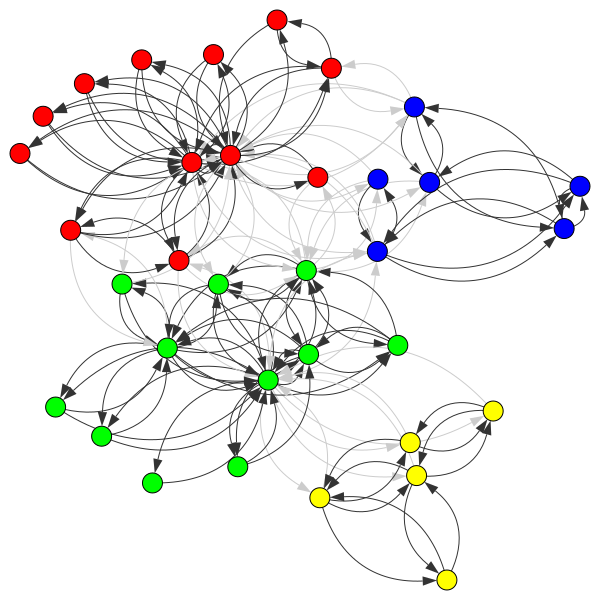

In [11]:
import leidenalg as leiden 
import igraph as ig
import networkx as nx

G = nx.karate_club_graph()
G = nx.DiGraph(G)
G = ig.Graph.from_networkx(G)
#partition = leiden.find_partition(G, leiden.ModularityVertexPartition, n_iterations=-1)
partition = leiden.find_partition(G, leiden.RBConfigurationVertexPartition, n_iterations=-1, resolution_parameter=1)
for i , community in enumerate(partition):
    print(f"Community {i}: {community}")
ig.plot(partition)